<a href="https://colab.research.google.com/github/omerfalach/Death-Classification-FAERS/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
##Installations for google colab
!pip install category_encoders
!pip install --upgrade plotly
!pip install squarify

     |████████████████████████████████| 82 kB 218 kB/s 


In [ ]:
!pip install xboost

In [ ]:
###Project folder location
folder = '/content/drive/MyDrive/Colab Notebooks/Project/'

In [ ]:
import sys
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import pytz
import pickle
import dill as dillpickle
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
import os
import warnings
import random
from sklearn.preprocessing import StandardScaler
import requests
from category_encoders import TargetEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc,precision_recall_curve,ConfusionMatrixDisplay
import plotly.express as px
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from datetime import datetime as dt
import gc
###Import project_plots.py
py_file_location = folder+"scripts/"
sys.path.append(os.path.abspath(py_file_location))
import project_plots as op

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading Data

In [ ]:
##Loading Data
data = pd.read_csv(folder+"preprocessed_files/dataset.csv")

In [ ]:
data.head(10)

,primaryid,caseid,outc_cod,sex,age,age_cod,age_grp,wt,wt_cod,occr_country,init_fda_dt,fda_dt,event_dt,filename,indi_pt,#drugs_to_indi,index,drugname,role_cod,drugname_listed,role_cod_listed
0,36362202,3636220,OT,NaN,NaN,NaN,N,NaN,NaN,NL,20010405,20210902,NaN,DEMO21Q3,['Foetal exposure during pregnancy'],[1],35.0,OXCARBAZEPINE,PS,['OXCARBAZEPINE'],['PS']
1,41505154,4150515,OT,F,56.0,YR,NaN,56.00,KG,FR,20040607,20210712,200203.0,DEMO21Q3,"['Dyslipidaemia', 'HIV infection']","[1, 4]",364.0,EFAVIRENZ,PS,"['EFAVIRENZ', 'TENOFOVIR', 'LOPINAVIR RITONAV...","['PS', 'SS', 'SS', 'SS', 'C']"
2,58189452,5818945,HO,M,50.0,YR,NaN,NaN,NaN,IT,20050615,20210715,199811.0,DEMO21Q3,"['Immunosuppressant drug therapy', 'Renal tran...","[4, 4]",682.0,CYCLOSPORINE,PS,"['CYCLOSPORINE', 'CYCLOSPORINE', 'MYCOPHENOLAT...","['PS', 'SS', 'SS', 'SS', 'SS', 'SS', 'SS', 'SS']"
3,59253972,5925397,HO,M,28.0,YR,A,NaN,NaN,US,20051118,20210706,NaN,DEMO21Q3,['Staphylococcal infection'],[2],813.0,RIFAMPICIN,PS,"['RIFAMPICIN', 'RIFAMPICIN', 'VANCOMYCIN', 'VA...","['PS', 'SS', 'C', 'C']"
4,60937133,6093713,OT,F,52.0,YR,NaN,NaN,NaN,ES,20060719,20210809,NaN,DEMO21Q3,"['Hiatus hernia', 'Hypercholesterolaemia']","[1, 1]",1061.0,OMEPRAZOLE,PS,"['OMEPRAZOLE', 'LOVASTATIN']","['PS', 'C']"
5,62093183,6209318,LT,M,12.0,YR,NaN,NaN,NaN,GB,20070105,20210817,2007.0,DEMO21Q3,"['Abdominal pain', 'Pain']","[1, 3]",1284.0,MORPHINE SULFATE,PS,"['MORPHINE SULFATE', 'DICLOFENAC', 'PARACETAMO...","['PS', 'SS', 'SS', 'SS', 'SS', 'SS']"
6,62168708,6216870,OT,M,54.0,YR,NaN,NaN,NaN,GB,20070117,20210811,2006.0,DEMO21Q3,"['Diabetes mellitus', 'Ill-defined disorder', ...","[1, 50, 17, 4]",1310.0,ACTRAPID,PS,"['ACTRAPID', 'ACTRAPID', 'HEPARIN SODIUM', 'SO...","['PS', 'SS', 'SS', 'SS', 'SS', 'SS', 'SS', 'C'..."
7,62640203,6264020,DE,F,11.0,YR,NaN,NaN,NaN,DE,20070305,20210714,NaN,DEMO21Q3,['Acute lymphocytic leukaemia'],[5],1455.0,PREDNISONE,PS,"['VINCRISTINE SULFATE', 'PREDNISONE', 'METHOTR...","['SS', 'PS', 'SS', 'SS', 'SS']"
8,64186542,6418654,DE,M,2.0,YR,NaN,NaN,NaN,FR,20070907,20210827,NaN,DEMO21Q3,"['Immunosuppressant drug therapy', 'Renal tran...","[6, 3]",1998.0,METHYLPREDNISOLONE,PS,"['METHYLPREDNISOLONE', 'METHYLPREDNISOLONE', '...","['PS', 'SS', 'SS', 'SS', 'SS', 'SS', 'SS', 'SS..."
9,64339465,6433946,CA,F,NaN,NaN,N,3.33,KG,GB,20071003,20210903,NaN,DEMO21Q3,['Lower respiratory tract infection'],[1],2047.0,CIPROFLOXACIN MONOHYDROCHLORIDE,PS,['CIPROFLOXACIN MONOHYDROCHLORIDE'],['PS']


In [ ]:
data.columns

Index(['primaryid', 'caseid', 'outc_cod', 'sex', 'age', 'age_cod', 'age_grp',
       'wt', 'wt_cod', 'occr_country', 'init_fda_dt', 'fda_dt', 'event_dt',
       'filename', 'indi_pt', '#drugs_to_indi', 'index', 'drugname',
       'role_cod', 'drugname_listed', 'role_cod_listed'],
      dtype='object')

In [ ]:
#Dropping colmns
data = data.drop(columns = ['init_fda_dt','fda_dt', 'event_dt'])

In [ ]:
infor =op.info_new(data,ignore_features= ['primaryid','caseid','drugname_listed','role_cod_listed','indi_pt','#drugs_to_indi'])
infor

Object types:
Ctype   float64  object
Column        3       9
X is composed of 6048456 samples and 18 features.


,colName,Non-null values,Nunique,Dtype,Unique
0,outc_cod,6048456,7,object,"[OT, HO, LT, DE, CA, DS, RI]"
1,sex,5242584,6,object,"[nan, F, M, UNK, P, I, T]"
2,age,3847400,14284,float64,"[nan, 56.0, 50.0, 28.0, 52.0, 12.0, 54.0, 11.0..."
3,age_cod,3847771,6,object,"[nan, YR, MON, DY, DEC, WK, HR]"
4,age_grp,1095222,6,object,"[N, nan, A, E, C, T, I]"
5,wt,1382452,10259,float64,"[nan, 56.0, 3.33, 51.0, 3.48, 19.4, 2.76, 66.2..."
6,wt_cod,1382426,2,object,"[nan, KG, LBS]"
7,occr_country,5976744,235,object,"[NL, FR, IT, US, ES, GB, DE, JP, AU, MX, IN, I..."
8,filename,6048456,27,object,"[DEMO21Q3, DEMO21Q2, DEMO21Q1, DEMO20Q4, DEMO2..."
9,index,6048455,6046686,float64,"[35.0, 364.0, 682.0, 813.0, 1061.0, 1284.0, 13..."


# Dataset
The dataset contains 6 features (sex,age,wt,occr_country,drugname,drugname_listed,indi_pt) and columns which describe values in those features.
We can easily spot that age and wt have to be normailized.

The outc_cod is our label and will be converted to binary label. Death=1, Live=0. 

In [ ]:
#normlaize age column to years
def fixed_age(df,age,age_code):
    df.loc[(df[age]<=12) & df[age_code] == "DEC", age] = df[age]*10
    df.loc[df[age_code] == "MON", age] = df[age]/12
#     
    df.loc[df[age_code] == "MON", age] = df[age]/12
    df.loc[df[age_code]== "DY", age] = df[age]/365
    df.loc[df[age_code] == "WK", age] = df[age]/52
    df.loc[df[age_code] == "HR", age] = df[age]/8765.8127
    return df    
#normlaize wt column to kilograms
def fixed_weight(df,wt,wt_cod): 
        # unified weight unit
        df[wt] = df[wt].apply(pd.to_numeric, errors='coerce')
        df.loc[df[wt_cod] == "LBS", wt] = df[wt]  * 0.453592 # pounds
        df.loc[df[wt_cod]== "GMS", wt] = df[wt]* 0.001# grams
        return df
def fixed_label(df,label):
  df[label] = df[label].apply(lambda x: 1 if x=='DE' else 0)
  return df
def convert_str_to_list(x):
    try:
        z= x.strip('[]').replace("'", "").split(',')
        z1 = [f.strip() for f in z]
        return  z1
    except:
        return x # replace with any suitable placeholder value
data['indi_pt']= data['indi_pt'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
data['drugname_listed']= data['drugname_listed'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
data['role_cod_listed']= data['role_cod_listed'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
data_fixed = fixed_age(data,'age','age_cod')
data_fixed = fixed_weight(data_fixed,'wt', 'wt_cod')
data_fixed = fixed_label(data_fixed,'outc_cod')


In [ ]:
#count_indications_and_drugs_per_case
data_fixed['#drug_background'] = data_fixed['drugname_listed'].apply(lambda x: len(x) if type(x)!=float else x)
data_fixed['#indication_background'] = data_fixed['indi_pt'].apply(lambda x: len(x) if type(x)!=float else x)

In [ ]:
del data 
gc.collect()

586

# Outliers

In [ ]:
small_categorical = ['sex']
large_categorical = ['occr_country']
continuous = ['age','wt']
backgrounds = ['#drug_background','#indication_background'] 

### Outliers - Continuous Featuers
We will take a look at the distribution of different features.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f418ba71410>,
      dtype=object)

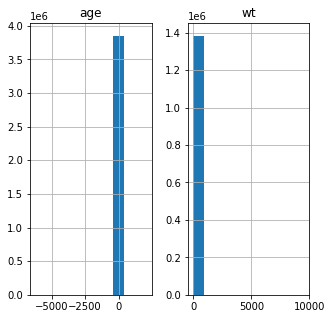

In [ ]:
data_fixed[continuous].hist(figsize=(5,5),bins = 10)

We can see that wt and age have outliers.
The next script will convert those outliers into np.nan

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2ab999350>,
      dtype=object)

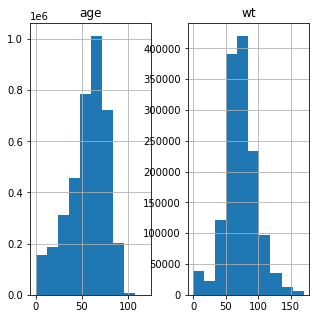

In [ ]:
##Convert outliers to np.nan
data_fixed.loc[(data_fixed['age']>=120) | (data_fixed['age']<=0) , 'age'] = np.nan
data_fixed.loc[(data_fixed['wt']>170), 'wt'] =  np.nan
data_fixed[continuous].hist(figsize=(5,5))



### Outliers - Categorical Featuers

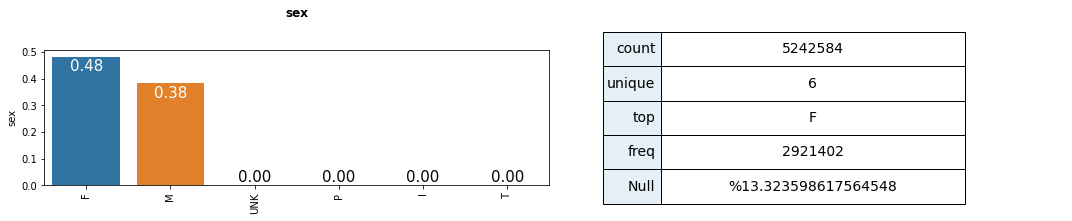

In [ ]:
##small categorical
op.plot_dist(data_fixed,small_categorical)

We can see some outliers and we will remove them in the following script

In [ ]:
#sex feature - dropping outliers
sex_outliers = ['UNK','P','I','T']
data_fixed =  data_fixed[~data_fixed['sex'].isin(sex_outliers)]

/content/drive/MyDrive/Colab Notebooks/Project/scripts/project_plots.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D[category] = D[category].astype('object')
/content/drive/MyDrive/Colab Notebooks/Project/scripts/project_plots.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D[category] = D[category].astype('object')


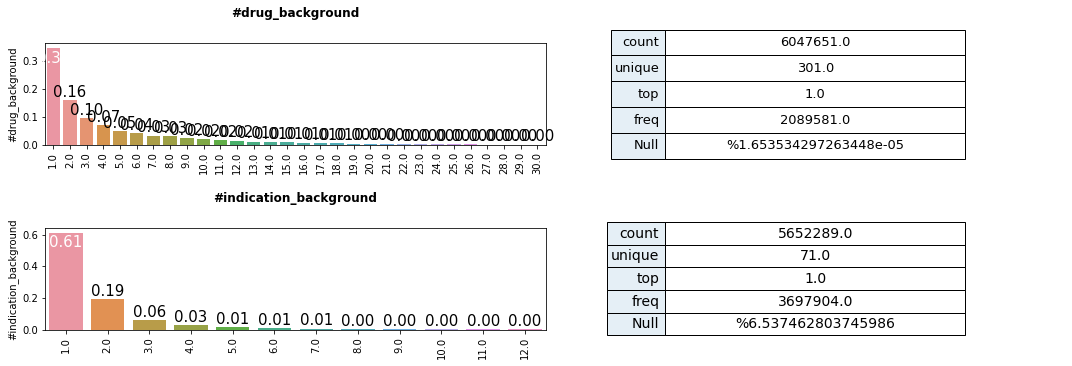

In [ ]:
op.plot_dist(data_fixed,['#drug_background','#indication_background'],limit = 0.001)

On both features we can see outliers but we will not remove them.



# Correlation
Examine the correlation between the diffrent features


In [ ]:
### Correlation - continuous featuers

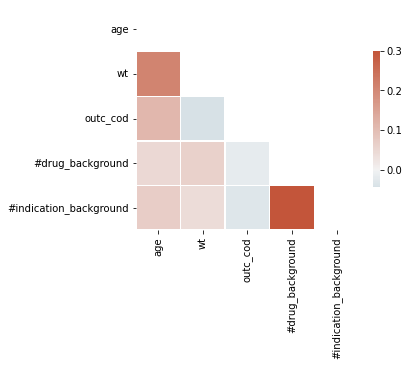

In [ ]:
op.corr_plot(data_fixed[["age","wt","outc_cod","#drug_background","#indication_background"]])

There is no high correlation between those features which make us remove on of them to avoid multicollinearity.

The correlation between #drug_background and #indication_background is not<br> relevant because drugs and indication will be trained separately anyway.

In [ ]:
### Correlation - categorical featuers

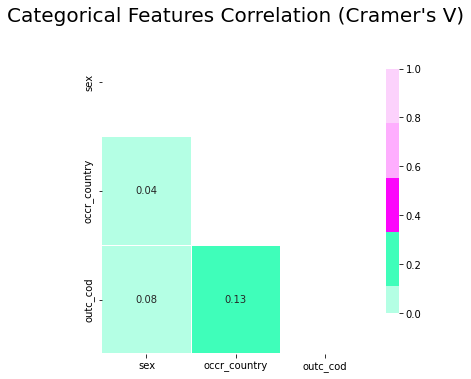

In [ ]:
op.plot_carmer_v_corr(data[["sex","occr_country","outc_cod"]])

There is no high correlation between those features which make us remove one of them to avoid multicollinearity.

# Correlation to Label

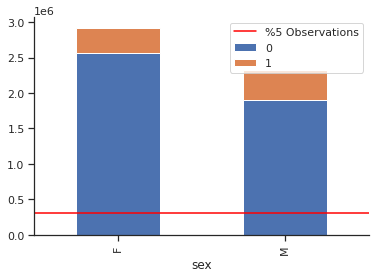

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


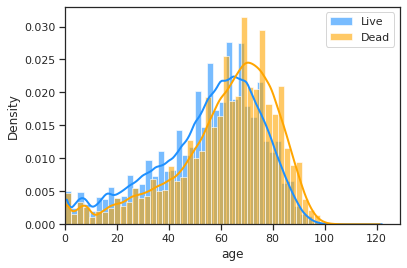

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


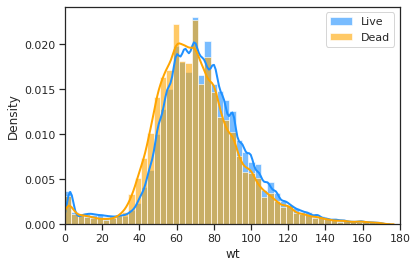

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


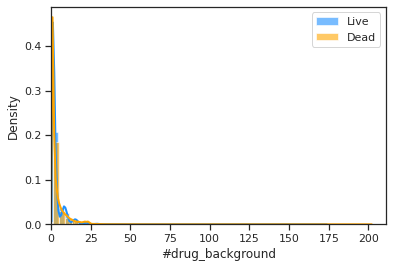

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


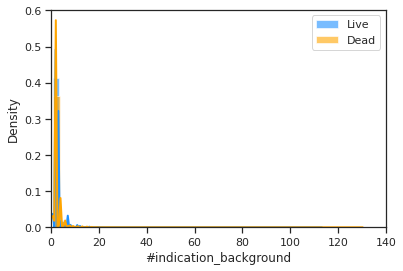

In [ ]:
# Small_CATEGORICAL_FEATURES = ['sex','#drug_background','#indication_background']
Small_CATEGORICAL_FEATURES = ['sex']

ignore_list = ['primaryid','caseid','outc_cod','occr_country','role_cod_listed','#drugs_to_indi','drugname','drugname_listed','indi_pt','wt_cod','role_cod','age_grp','age_cod','#drug_background','#indication_background']
for col in data_fixed.columns:
    if col in ignore_list:
        continue
    elif col in Small_CATEGORICAL_FEATURES:
        op.plot_label_corr_bar(data_fixed, col)
    else:
        op.plot_label_corr_hist(data_fixed, col)

We can see the following facts about the data:


*   **Sex**: Man is more likely to die than women but the diffrence is small.
*   **Age**: People older than 65 are more likely to die.
*   **Wt**: People between 35 to 60 kilograms are more likely to die. 






In [ ]:
op.treemap(data_fixed,'drugname','outc_cod')

In [ ]:
op.treemap(data_fixed,'occr_country','outc_cod')

We can see that development countries has more obersrvations but smaller chances to die.

For example:<br>
CA(Canda) has 466,584 observations and 8.6% chances to die and PK(Pakistan) has just 4,805 observations and 58% to die.

# Missing Values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



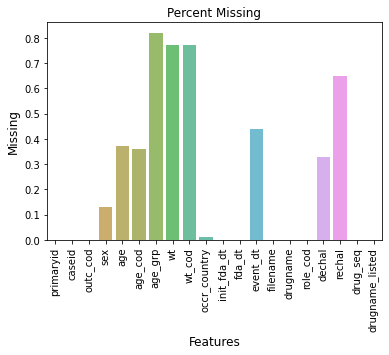

In [ ]:
op.plot_missing_values(data_fixed)

Wt has 75% missing values and we will remove this feature.<br>
We will fill sex feature randomaly and Age will be filled by chances we will calculate from our data.

# Data Balance

/content/drive/MyDrive/Colab Notebooks/Project/scripts/project_plots.py:99: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



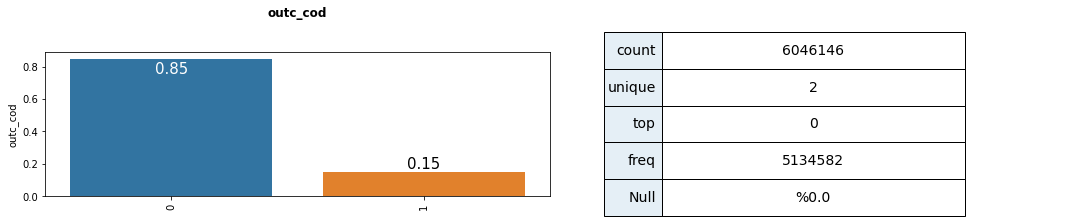

In [ ]:
op.plot_dist(data_fixed,['outc_cod'])

We can see that just 15% of cases ended with death.
We assume that those proportions are normal for keep them in our training we will use StratifiedKFold while we split the Dataset into train and test.

# Split Train-Test

In [ ]:
data_fixed= data_fixed.dropna(subset=['outc_cod', 'occr_country'])
datastra = data_fixed.drop(columns = ['primaryid','caseid','wt_cod','role_cod','age_grp','age_cod','wt','#drugs_to_indi'])
del data_fixed
gc.collect()


In [ ]:
datastra['outc_cod'] = datastra['outc_cod'].astype(int)
def get_stratified_split(x,y,test_size = 0.2):
    n_folds = int(round(1/test_size))
    skf = StratifiedKFold(n_splits = n_folds, random_state = 0, shuffle = True)
    for tr_ind, test_ind in skf.split(x,y):
        break
    return tr_ind,test_ind

tr_ind, test_ind = get_stratified_split(np.zeros(len(datastra)),datastra['outc_cod'],test_size =0.2)
features = list(datastra.columns)
features.remove('outc_cod')
train_features = datastra[features].iloc[tr_ind]
test_features = datastra[features].iloc[test_ind]
train_labels = datastra['outc_cod'].iloc[tr_ind]
test_labels = datastra['outc_cod'].iloc[test_ind]

In [ ]:
##Save splitted_files
train_features.to_csv(folder+'preprocessed_files/train_features.csv',index = False)
test_features.to_csv(folder+'preprocessed_files/test_features.csv',index = False)
train_labels.to_csv(folder+'preprocessed_files/train_labels.csv',index = False)
test_labels.to_csv(folder+'preprocessed_files/test_labels.csv',index = False)